<a href="https://colab.research.google.com/github/cepdnaclk/e18-4yp-Predicting-Forex-Currency-Exchange-Rate-using-Machine-Learning/blob/main/models/GBPUSD/IN1_LSTM_Bayesian_Version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=6443526b04b0ffd7ab7e3c85c3fa1021e24ee9f2a5e7da9d93974e36fbbc462e
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
import pandas as pd
import pandas_ta as ta

data = pd.read_csv('EURUSD=X (1).csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-31,1.112991,1.117943,1.112656,1.113115,1.113115,0
1,2019-06-03,1.117343,1.121100,1.116221,1.117406,1.117406,0
2,2019-06-04,1.124556,1.127777,1.122776,1.124632,1.124632,0
3,2019-06-05,1.125505,1.130454,1.123987,1.125404,1.125404,0
4,2019-06-06,1.122725,1.130787,1.122385,1.122902,1.122902,0
...,...,...,...,...,...,...,...
1301,2024-05-27,1.084763,1.086720,1.084175,1.084763,1.084763,0
1302,2024-05-28,1.086189,1.088945,1.085906,1.086189,1.086189,0
1303,2024-05-29,1.085187,1.085894,1.080953,1.085187,1.085187,0
1304,2024-05-30,1.080182,1.084599,1.078900,1.080182,1.080182,0


In [ ]:
data['T-4'] = data['Close']
data['T-3'] = data['Close'].shift(-1)
data['T-2'] = data['Close'].shift(-2)
data['T-1'] = data['Close'].shift(-3)
data['T0'] = data['Close'].shift(-4)

data['SMA_5_H'] = ta.sma(data['High'], length=5).shift(-4)
data['SMA_5_L'] = ta.sma(data['Low'], length=5).shift(-4)
data['EMA_5_C'] = ta.ema(data['Close'], length=5).shift(-4)
data['RSI'] = ta.rsi(data['Close'], length=14).shift(-14)

#Closing value of the next day
data['T_F'] = data['Close'].shift(-5)

print(data.head(10))


         Date      Open      High       Low     Close  Adj Close  Volume  \
0  2019-05-31  1.112991  1.117943  1.112656  1.113115   1.113115       0   
1  2019-06-03  1.117343  1.121100  1.116221  1.117406   1.117406       0   
2  2019-06-04  1.124556  1.127777  1.122776  1.124632   1.124632       0   
3  2019-06-05  1.125505  1.130454  1.123987  1.125404   1.125404       0   
4  2019-06-06  1.122725  1.130787  1.122385  1.122902   1.122902       0   
5  2019-06-07  1.127548  1.134816  1.125315  1.127650   1.127650       0   
6  2019-06-10  1.131900  1.132695  1.129203  1.132016   1.132016       0   
7  2019-06-11  1.131836  1.133273  1.130480  1.131811   1.131811       0   
8  2019-06-12  1.132939  1.134301  1.130851  1.132952   1.132952       0   
9  2019-06-13  1.129305  1.130500  1.127116  1.129561   1.129561       0   

        T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
0  1.113115  1.117406  1.124632  1.125404  1.122902  1.125612  1.119605   
1  1.117406  

In [ ]:
print(data.tail(10))

            Date      Open      High       Low     Close  Adj Close  Volume  \
1296  2024-05-20  1.087548  1.088495  1.085505  1.087548   1.087548       0   
1297  2024-05-21  1.086083  1.087548  1.084599  1.086083   1.086083       0   
1298  2024-05-22  1.085517  1.086484  1.082251  1.085517   1.085517       0   
1299  2024-05-23  1.082520  1.086130  1.081303  1.082520   1.082520       0   
1300  2024-05-24  1.081268  1.085658  1.080614  1.081268   1.081268       0   
1301  2024-05-27  1.084763  1.086720  1.084175  1.084763   1.084763       0   
1302  2024-05-28  1.086189  1.088945  1.085906  1.086189   1.086189       0   
1303  2024-05-29  1.085187  1.085894  1.080953  1.085187   1.085187       0   
1304  2024-05-30  1.080182  1.084599  1.078900  1.080182   1.080182       0   
1305  2024-05-31  1.083658  1.088495  1.081432  1.087903   1.087903       0   

           T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
1296  1.087548  1.086083  1.085517  1.082520  1.0812

In [ ]:
# Dropping NaN values
data.dropna(inplace=True)

print(data.tail(10))


            Date      Open      High       Low     Close  Adj Close  Volume  \
1282  2024-04-30  1.071570  1.073653  1.068433  1.071570   1.071570       0   
1283  2024-05-01  1.066655  1.068867  1.065008  1.066655   1.066655       0   
1284  2024-05-02  1.072156  1.073076  1.067578  1.072156   1.072156       0   
1285  2024-05-03  1.073307  1.080941  1.072501  1.073307   1.073307       0   
1286  2024-05-06  1.075812  1.079214  1.075639  1.075812   1.075812       0   
1287  2024-05-07  1.076751  1.078981  1.075581  1.076751   1.076751       0   
1288  2024-05-08  1.075049  1.075847  1.073572  1.075049   1.075049       0   
1289  2024-05-09  1.074691  1.078283  1.072513  1.074691   1.074691       0   
1290  2024-05-10  1.078516  1.079331  1.076206  1.078516   1.078516       0   
1291  2024-05-13  1.077041  1.080731  1.076646  1.077041   1.077041       0   

           T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
1282  1.071570  1.066655  1.072156  1.073307  1.0758

In [ ]:
data = data[['Date', 'T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI','T_F']]

data

,Date,T-4,T-3,T-2,T-1,T0,SMA_5_H,SMA_5_L,EMA_5_C,RSI,T_F
0,2019-05-31,1.113115,1.117406,1.124632,1.125404,1.122902,1.125612,1.119605,1.120692,55.267624,1.127650
1,2019-06-03,1.117406,1.124632,1.125404,1.122902,1.127650,1.128987,1.122137,1.123011,63.441525,1.132016
2,2019-06-04,1.124632,1.125404,1.122902,1.127650,1.132016,1.131306,1.124733,1.126013,72.027440,1.131811
3,2019-06-05,1.125404,1.122902,1.127650,1.132016,1.131811,1.132405,1.126274,1.127946,73.212019,1.132952
4,2019-06-06,1.122902,1.127650,1.132016,1.131811,1.132952,1.133174,1.127647,1.129614,67.242171,1.129561
...,...,...,...,...,...,...,...,...,...,...,...
1287,2024-05-07,1.076751,1.075049,1.074691,1.078516,1.077041,1.078635,1.074904,1.076244,57.953711,1.079354
1288,2024-05-08,1.075049,1.074691,1.078516,1.077041,1.079354,1.079406,1.075316,1.077280,59.751999,1.081455
1289,2024-05-09,1.074691,1.078516,1.077041,1.079354,1.081455,1.081722,1.076874,1.078672,57.878800,1.088981
1290,2024-05-10,1.078516,1.077041,1.079354,1.081455,1.088981,1.084002,1.079475,1.082108,49.526761,1.086779


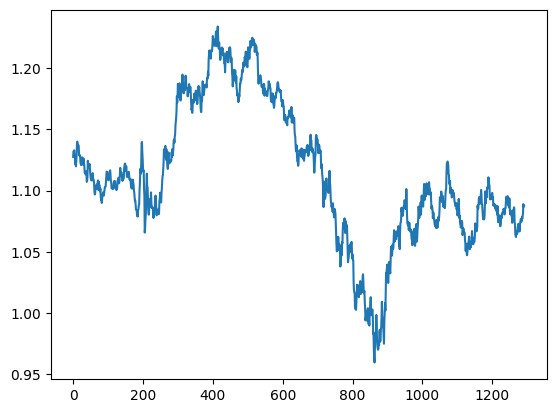

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['T_F'])

In [ ]:
dates=data['Date'].to_numpy()
middle_matrix =data[['T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI']].to_numpy()
X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
Y=data['T_F']

print(dates.shape)
print(X.shape)
print(Y.shape)

(1292,)
(1292, 9, 1)
(1292,)


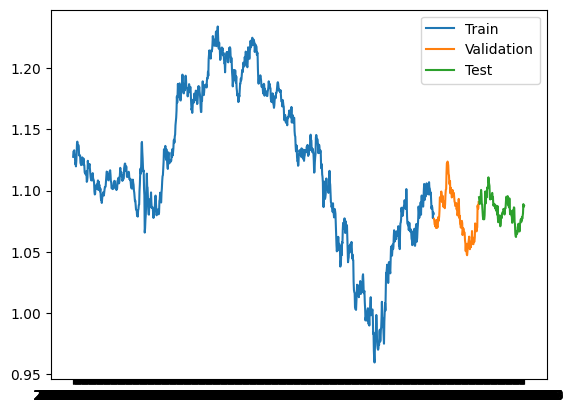

In [ ]:
q_80 = int(len(dates) * .8) #change to 0.8
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], Y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], Y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import numpy as np
import time

def evaluate_network(lstm_units_1,epochs,learning_rate,dense_units_1,dense_units_2):

  lstm_units_1=int(lstm_units_1)
  epochs=int(epochs)
  dense_units_1=int(dense_units_1)
  dense_units_2=int(dense_units_2)

  model = Sequential([layers.Input((9, 1)),
                      layers.LSTM(lstm_units_1),
                      layers.Dense(dense_units_1, activation='relu'),
                      layers.Dense(dense_units_2, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_absolute_error'])


  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0)

  # Return the loss (or another metric that you want to minimize)
  val_loss=min(history.history['val_loss'])
  loss=min(history.history['loss'])

  return -(val_loss*loss)  # Negative because BayesianOptimization maximizes, but we want to minimize loss



pbounds = {
    'lstm_units_1': (20, 300),
    'learning_rate': (1e-6, 1e-2),
    'epochs': (10, 150),
    'dense_units_1': (10, 200),
    'dense_units_2': (10, 200)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
    )

# Run the optimization
start_time = time.time()
optimizer.maximize(init_points=20, n_iter=40)
time_took = (time.time() - start_time)/60


# Get the best hyperparameters
print(f"Total runtime in mins: {time_took}")
best_params = optimizer.max['params']
print(f"Best hyperparameters: {best_params}")


|   iter    |  target   | dense_... | dense_... |  epochs   | learni... | lstm_u... |
-------------------------------------------------------------------------------------
| 1         | -8.613e-0 | 89.23     | 146.9     | 10.02     | 0.003024  | 61.09     |
| 2         | -3.296e-0 | 27.54     | 45.39     | 58.38     | 0.003968  | 170.9     |
| 3         | -2.615e-0 | 89.65     | 140.2     | 38.62     | 0.008781  | 27.67     |
| 4         | -2.367e-0 | 137.4     | 89.29     | 88.22     | 0.001405  | 75.47     |
| 5         | -3.837e-0 | 162.1     | 194.0     | 53.88     | 0.006924  | 265.4     |
| 6         | -6.571e-0 | 180.0     | 26.16     | 15.47     | 0.001699  | 265.9     |
| 7         | -2.358e-0 | 28.69     | 90.01     | 144.1     | 0.005332  | 213.7     |
| 8         | -2.13e-09 | 69.95     | 140.4     | 126.8     | 0.0001839 | 230.0     |
| 9         | -2.028e-0 | 197.9     | 152.2     | 49.26     | 0.007893  | 48.9      |
| 10        | -2.507e-0 | 95.1      | 182.6     | 51.1

Epoch 1/40
33/33 [==============================] - 5s 22ms/step - loss: 0.5939 - mean_absolute_error: 0.7071 - val_loss: 0.0196 - val_mean_absolute_error: 0.1359
Epoch 2/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0098 - mean_absolute_error: 0.0825 - val_loss: 0.0048 - val_mean_absolute_error: 0.0622
Epoch 3/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0485 - val_loss: 0.0018 - val_mean_absolute_error: 0.0366
Epoch 4/40
33/33 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0443 - val_loss: 0.0014 - val_mean_absolute_error: 0.0322
Epoch 5/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0421 - val_loss: 0.0012 - val_mean_absolute_error: 0.0307
Epoch 6/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_absolute_error: 0.0407 - val_loss: 9.8874e-04 - val_mean_absolute_error: 0.0274
Epoch 7/40
33/33 [=====

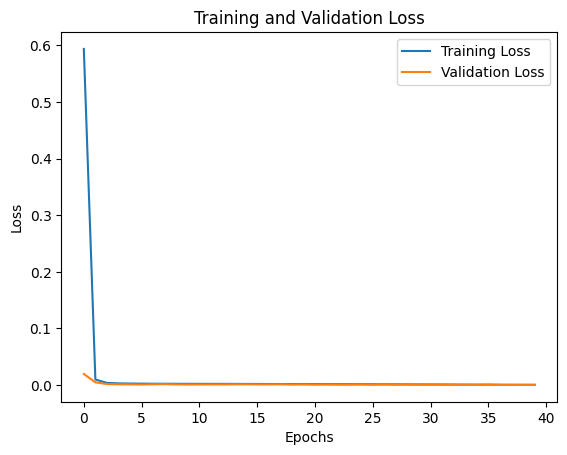

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# model = Sequential([layers.Input((9, 1)),
#                     layers.LSTM(64),
#                     layers.Dense(1)])

model = Sequential([layers.Input((9, 1)),
                   layers.LSTM(278),
                   layers.Dense(75, activation='relu'),
                   layers.Dense(137, activation='relu'),
                   layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.000076646),
              metrics=['mean_absolute_error'])


history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40)

print(history.history.keys())

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

33/33 [==============================] - 0s 2ms/step


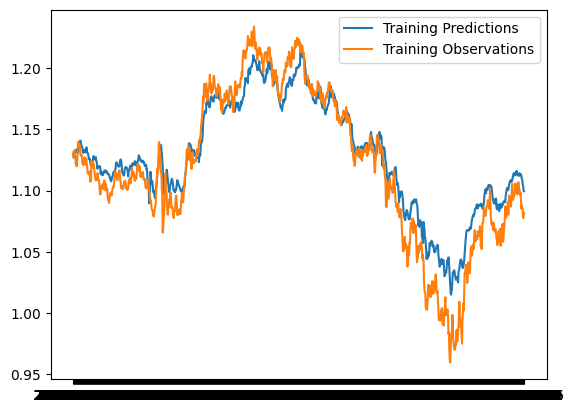

In [ ]:
from sklearn.metrics import mean_squared_error

train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

157.55265776258483


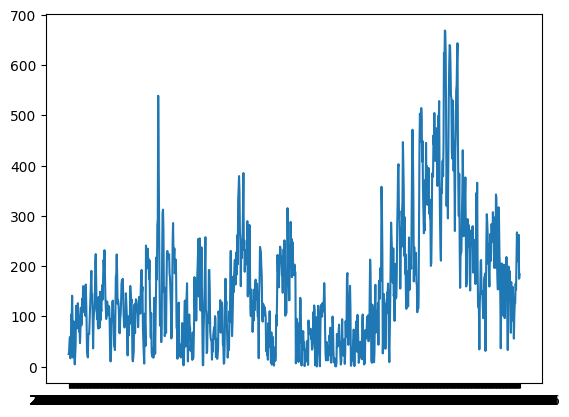

In [ ]:
import numpy as np

basis_point_value=0.0001  #For EURUSD pair
train_data_basis_point_diff=((train_predictions/basis_point_value).flatten()-y_train/basis_point_value).abs()
plt.plot(dates_train, train_data_basis_point_diff)

average_train_data_basis_point_diff=np.mean(train_data_basis_point_diff)
print(average_train_data_basis_point_diff)

5/5 [==============================] - 0s 3ms/step


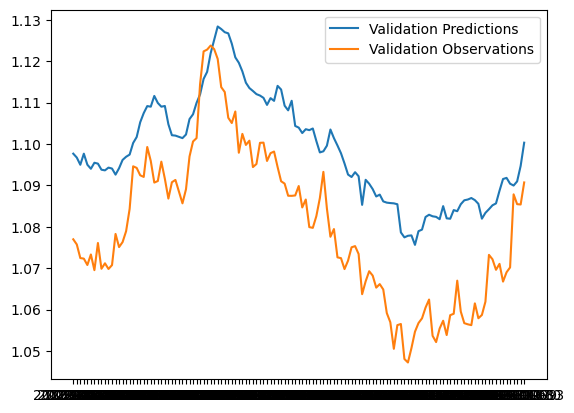

In [ ]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

185.71135598352754


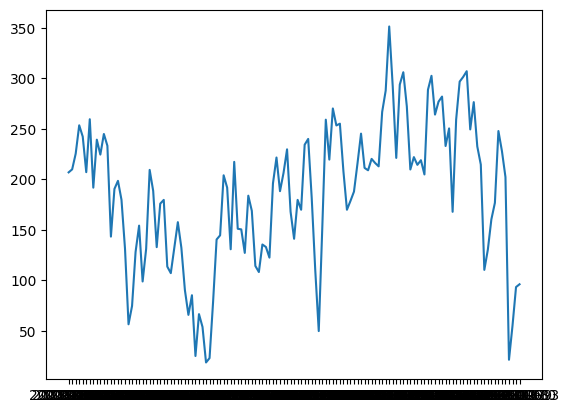

In [ ]:
basis_point_value=0.0001  #For EURUSD pair
validation_data_basis_point_diff=((val_predictions/basis_point_value).flatten()-y_val/basis_point_value).abs()
plt.plot(dates_val, validation_data_basis_point_diff)

print(np.mean(validation_data_basis_point_diff))

5/5 [==============================] - 0s 4ms/step


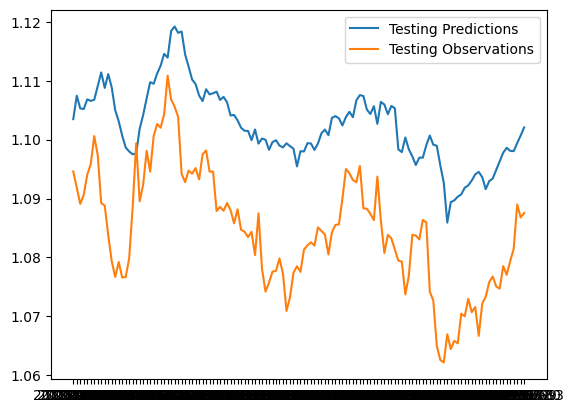

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Assuming test_predictions and y_test are lists or numpy arrays
# Calculate MSE and MAE
mse = mean_squared_error(y_test, test_predictions)
print("Mean Square Error:", mse)
mae=mean_absolute_error(y_test, test_predictions)
print("Mean Absolute Error:", mae)

Mean Square Error: 0.00035047095088217397
Mean Absolute Error: 0.017766623578350363


177.66651983173136


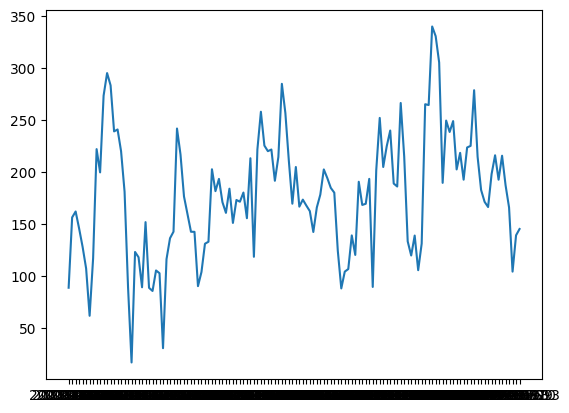

In [ ]:
basis_point_value=0.0001  #For EURUSD pair
test_data_basis_point_diff=((test_predictions/basis_point_value).flatten()-y_test/basis_point_value).abs()
plt.plot(dates_test, test_data_basis_point_diff)

print(np.mean(test_data_basis_point_diff))

In [ ]:
#Start Trading with 1000 USD with model


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_predictions[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_predictions[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)


130
992.859459434768
base


In [ ]:
#Start Trading with 1000 USD with actual values


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_data[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_data[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)

130
1186.967468350016
base


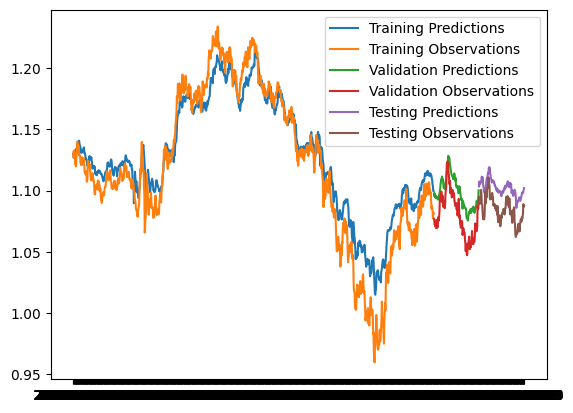

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 39ms/step


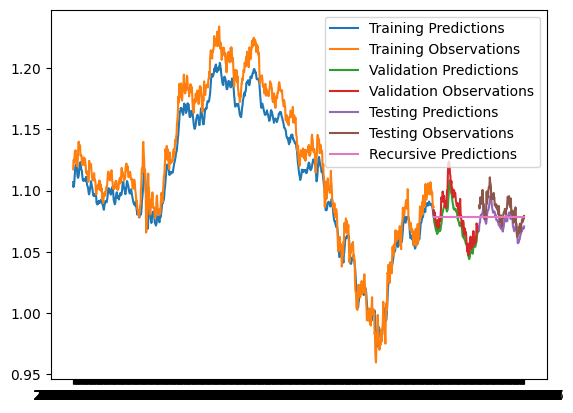

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])